In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-9k444m6h
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-9k444m6h
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install torchcam


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
import cv2

In [4]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


In [5]:
image = '/content/16.jpg'
img = cv2.imread(image)
img = cv2.resize(img, (576, 1024))

rgb_img = np.float32(img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [6]:
output

OrderedDict([('out',
              tensor([[[[ 7.7176,  7.7176,  7.7176,  ...,  8.6578,  8.6578,  8.6578],
                        [ 7.7176,  7.7176,  7.7176,  ...,  8.6578,  8.6578,  8.6578],
                        [ 7.7176,  7.7176,  7.7176,  ...,  8.6578,  8.6578,  8.6578],
                        ...,
                        [ 7.4803,  7.4803,  7.4803,  ...,  7.4395,  7.4395,  7.4395],
                        [ 7.4803,  7.4803,  7.4803,  ...,  7.4395,  7.4395,  7.4395],
                        [ 7.4803,  7.4803,  7.4803,  ...,  7.4395,  7.4395,  7.4395]],
              
                       [[-1.4166, -1.4166, -1.4166,  ..., -0.9665, -0.9665, -0.9665],
                        [-1.4166, -1.4166, -1.4166,  ..., -0.9665, -0.9665, -0.9665],
                        [-1.4166, -1.4166, -1.4166,  ..., -0.9665, -0.9665, -0.9665],
                        ...,
                        [-1.8141, -1.8141, -1.8141,  ..., -1.2005, -1.2005, -1.2005],
                        [-1.8141, -1.8141, -1

In [7]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)["out"]

model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

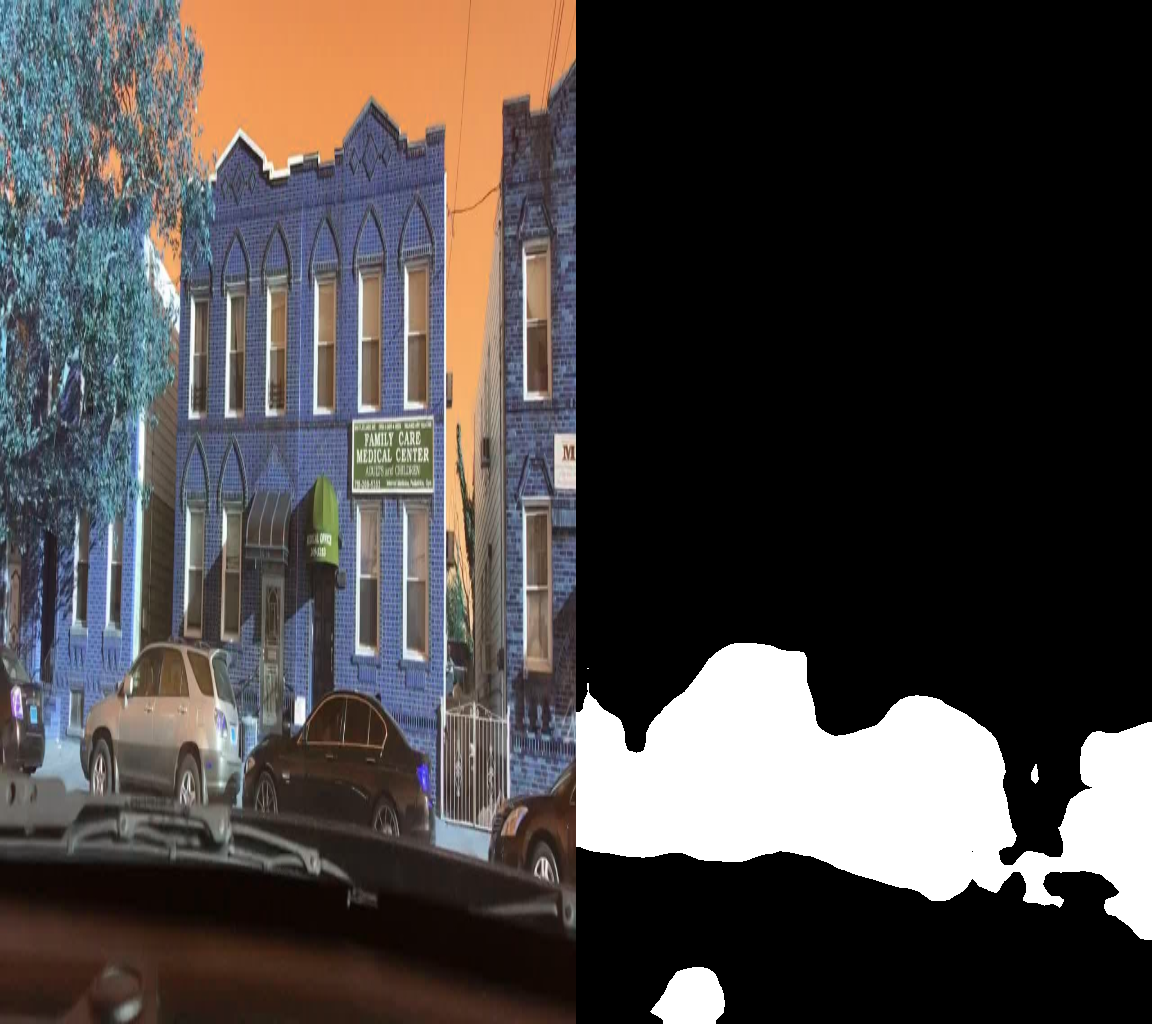

In [8]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((img, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

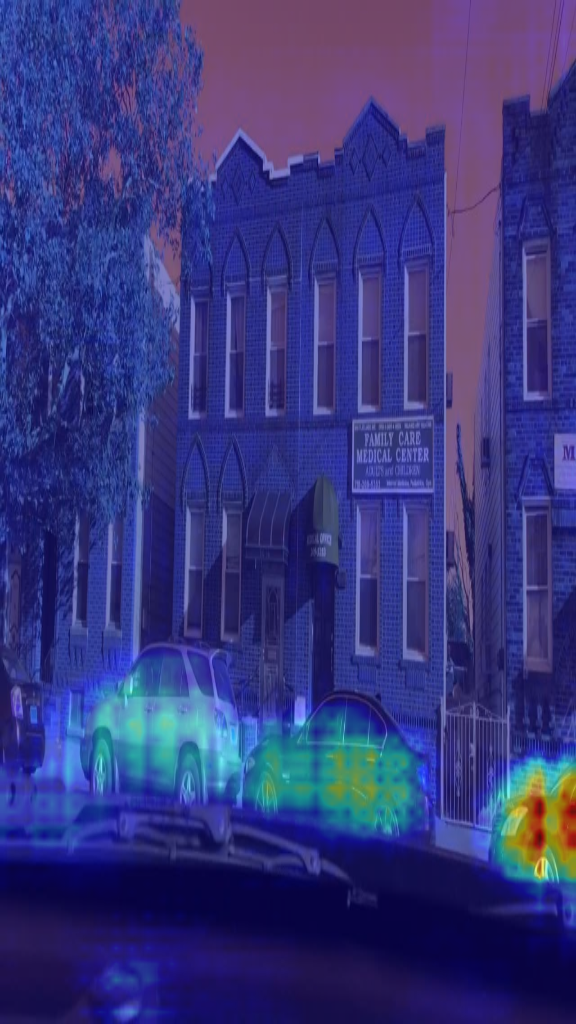

In [9]:

from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()


target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

In [10]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import scipy.io
def compute_pcc(saliency_flat, human_attention_flat):
    pcc, _ = pearsonr(saliency_flat, human_attention_flat)
    return pcc

def compute_rmse(saliency_flat, human_attention_flat):
    rmse = np.sqrt(mean_squared_error(saliency_flat, human_attention_flat))
    return rmse

def compute_srocc(saliency_flat, human_attention_flat):
    srocc, _ = spearmanr(saliency_flat, human_attention_flat)
    return srocc

attn_path = '/content/16_GSmo_30.mat'

mat_data = scipy.io.loadmat(attn_path)
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Aug 31 21:27:28 2022',
 '__version__': '1.0',
 '__globals__': [],
 'output_map_norm': array([[2.64940133e-09, 2.41081296e-09, 2.19023086e-09, ...,
         3.48380786e-09, 3.18481217e-09, 2.90704312e-09],
        [2.04234407e-09, 1.85821534e-09, 1.68800836e-09, ...,
         2.68650223e-09, 2.45564235e-09, 2.24120808e-09],
        [1.57102756e-09, 1.42923070e-09, 1.29817475e-09, ...,
         2.06725572e-09, 1.88938410e-09, 1.72419610e-09],
        ...,
        [5.71027417e-09, 5.19779433e-09, 4.72378116e-09, ...,
         7.50081589e-09, 6.85950444e-09, 6.26342542e-09],
        [4.43007137e-09, 4.03203189e-09, 3.66392326e-09, ...,
         5.82121809e-09, 5.32287954e-09, 4.85976548e-09],
        [3.42958321e-09, 3.12108647e-09, 2.83582952e-09, ...,
         4.50812653e-09, 4.12170912e-09, 3.76266466e-09]])}

In [11]:
human_attention_map = mat_data['output_map_norm']
human_attention_map = np.array(human_attention_map)
human_attention_map = human_attention_map.flatten()
grayscale_cam = grayscale_cam.flatten()

pcc = compute_pcc(grayscale_cam, human_attention_map)
rmse = compute_rmse(grayscale_cam, human_attention_map)
srocc = compute_srocc(grayscale_cam, human_attention_map)

print(f"PCC: {pcc}")
print(f"RMSE: {rmse}")
print(f"SROCC: {srocc}")

PCC: 0.2732025699221407
RMSE: 0.1280490380229643
SROCC: 0.014123942846947915


In [16]:
import numpy as np
from skimage.transform import resize

def insertion_score(image, saliency_map, model_fn, steps=100):
    image = image.copy()
    h, w = image.shape[0:2]
    sal_order = np.argsort(-saliency_map)  # Most salient first

    baseline = np.zeros_like(image)
    scores = []

    for i in range(1, steps + 1):
        mask = np.zeros(h * w)
        mask[sal_order[:int(i * h * w / steps)]] = 1
        mask = mask.reshape(h, w)
        mask = np.stack([mask]*3, axis=2)
        inserted_image = baseline * (1 - mask) + image * mask
        scores.append(model_fn(inserted_image))

    return np.mean(scores)

def deletion_score(image, saliency_map, model_fn, steps=50):
    image = image.copy()
    h, w = image.shape[0:2]
    sal_order = np.argsort(-saliency_map)

    scores = []

    for i in range(1, steps + 1):
        mask = np.ones(h * w)
        mask[sal_order[:int(i * h * w / steps)]] = 0
        mask = mask.reshape(h, w)
        mask = np.stack([mask]*3, axis=2)
        deleted_image = image * mask
        scores.append(model_fn(deleted_image))

    return np.mean(scores)


In [13]:
import torch
import torch.nn.functional as F

def model_fn(img_np):
    import torchvision.transforms as T
    img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float()

    # No normalization needed for YOLOv5 — it's trained on [0,1] scaled images
    img_tensor = img_tensor
    with torch.no_grad():
        results = model(img_tensor)[0]  # this gives predictions
        if results.shape[0] == 0:
            return 0.0  # No detection
        else:
            # Objectness * class probability = confidence
            best_conf = results[:, 4] * results[:, 5:].max(dim=1)[0]
            return best_conf.max().item()



In [ ]:
insw = insertion_score(rgb_img,grayscale_cam,model_fn)
delw = deletion_score(rgb_img,grayscale_cam,model_fn)
print(f"Insertion Score: {insw}")
print(f"Deletion Score: {delw}")